# Lab 4

**Hugo Yeremian - Martín Pasche**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from statsmodels.stats.diagnostic import het_arch

from typing import List, Tuple, Dict, Any, Optional

from scipy.stats import poisson
from scipy.optimize import curve_fit

## 1 - Brownian motions with Poisson sampling

### Usefull Functions

#### Poisson sampling simulation functions

In [3]:
def time_homogeneous_poisson_process(lmbda, T):
    
    n_events = poisson.rvs(lmbda*T)
    random_positions = np.random.uniform(0, T, n_events)
    random_positions.sort()
    
    return random_positions

def nhpp_thinning (lmbda, T):
    
    # Finding the highest rate
    x_space = np.linspace(0, T, int(T * 1000))
    y_space = lmbda(x_space)
    y_space = y_space[~np.isnan(y_space)]
    lmbda_star = int( np.ceil( np.max(y_space) ) ) + 1
    
    homogenous_poisson_process = time_homogeneous_poisson_process(
        lmbda_star, T)
    
    # Thinning
    thinning_prob = np.random.uniform(0, 1, len(homogenous_poisson_process))
    lam_values = lmbda(homogenous_poisson_process)
    mask = thinning_prob < ( lam_values / lmbda_star )
    
    return homogenous_poisson_process[mask]

#### Correlated BM simulations

In [4]:
def simulated_correlated_BMs (rho : float, 
                              sigmas : List[float], 
                              T : List[np.ndarray], 
                              seed : int = None):
    
    if seed is not None:
        np.random.seed(seed)
    else:
        #np.random.seed(42)
        pass
    
    new_T = []
    for t in T:
        new_T.append( np.concat([[0], t]))
        
    T = new_T    
    Ts = np.sort( np.unique( np.concatenate(T) ) )
    dTs = np.diff(Ts)
        
    n_steps = len(dTs)    
        
    W1 = np.zeros(n_steps + 1)
    W2 = np.zeros(n_steps + 1)
    
    for i in range(n_steps):
        Z1 = np.random.normal(0, 1)
        Z2 = np.random.normal(0, 1)
        
        dW1 = np.sqrt(dTs[i]) * Z1
        dW2 = np.sqrt(dTs[i]) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)
        
        W1[i + 1] = W1[i] + dW1
        W2[i + 1] = W2[i] + dW2
        
    p1 = sigmas[0] * W1
    p2 = sigmas[1] * W2
    
    df = pd.DataFrame({
        'p1': p1,
        'p2': p2
    }, index = Ts)
    
    # The first values is at time 0
    # It was implemented to have the price start at time 0 for the 
    # Brownian motion. else, the first value 0 would be the first trade.
    return df.iloc[1:]

#### Examples of the functions usage

In [5]:
rho = 0.4
mu = [0.4, 0.7]
max_time = 1_000
sigmas = [0.5, 0.2]

T1 = time_homogeneous_poisson_process(mu[0], max_time)
T2 = time_homogeneous_poisson_process(mu[1], max_time)

df_simulation = simulated_correlated_BMs(rho, sigmas, [T1, T2])
df_simulation

,p1,p2
0.885733,0.152614,0.094297
2.121189,-0.575264,-0.073006
2.193466,-0.532136,-0.060440
2.410338,-0.946747,-0.033040
2.537490,-1.135294,-0.099679
...,...,...
991.646775,2.434731,-7.217841
992.613267,2.278267,-7.314622
993.959398,2.182369,-7.286428
995.803005,2.072390,-7.400645


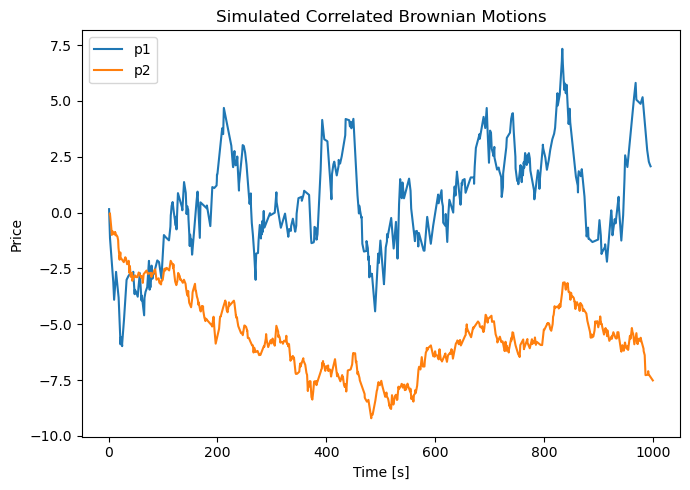

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(df_simulation.loc[T1].index, df_simulation.loc[T1]['p1'], label='p1')
plt.plot(df_simulation.loc[T2].index, df_simulation.loc[T2]['p2'], label='p2')
plt.xlabel('Time [s]')
plt.ylabel('Price')
plt.legend()
plt.title('Simulated Correlated Brownian Motions')
plt.tight_layout()
plt.show()

### Hayashi - Yoshida estimator

The Hayashi-Yoshida estimator is given by the following formula:

$$
U_n = \sum_{i, j} \Delta P_1(I^i)\Delta P_2(J^j) \mathbf{1}\{I^i \cap J^j \neq \emptyset\}
$$

We can do a direct implementation of this formula using two `for` loops.

In [7]:
def hayashi_yoshida_cov_estimator(df_entry: pd.DataFrame = pd.DataFrame(),
                              Ts : List[np.array] = []) -> float:
    
    try:
        if df_entry.empty:
            raise ValueError("DataFrame is empty.")
        
        df = df_entry.copy()
        
        T1 = Ts[0]
        T2 = Ts[1]
        
        p1 = df.loc[T1][0]
        p2 = df.loc[T2][1]
        
        covariance_estimator = 0.0
        
        for i in range(len(T1) - 1):
            for j in range(len(T2) - 1):
                
                I = [T1[i], T1[i+1]]
                J = [T2[j], T2[j+1]]
                
                if (I[0] < J[0] and J[0] < I[1]) or \
                    (I[0] < J[1] and J[1] < I[1]):
                        
                    delta_p1 = p1.iloc[i+1] - p1.iloc[i]
                    delta_p2 = p2.iloc[j+1] - p2.iloc[j]
                    
                    covariance_estimator += delta_p1 * delta_p2
                    
        return covariance_estimator
                    
    except Exception as e:
        print(f"Error: {e}")
        return 0.0

However, we can use a two pointer method to speed up the process, making it $O(n + m)$ instead of $O(n^2)$

In [8]:
def hayashi_yoshida_cov_estimator_optimized(df_entry: pd.DataFrame,
                                         Ts: List[np.array]) -> float:
    try:
        if df_entry.empty:
            raise ValueError("DataFrame is empty.")
        
        df = df_entry.copy()
        T1 = Ts[0]
        T2 = Ts[1]
        
        p1 = df.loc[T1].iloc[:, 0].values
        p2 = df.loc[T2].iloc[:, 1].values

        delta_p1 = np.diff(p1)  
        delta_p2 = np.diff(p2)  
        

        i, j = 0, 0
        covariance_estimator = 0.0
        n1 = len(T1) - 1  
        n2 = len(T2) - 1  

        # Loop until one set of intervals is fully processed
        while i < n1 and j < n2:
            
            startI, endI = T1[i], T1[i+1]
            startJ, endJ = T2[j], T2[j+1]
            
            # Check for no overlap:
            if endI <= startJ:
                # i-th interval ends before j-th interval starts
                i += 1
            elif endJ <= startI:
                # j-th interval ends before i-th interval starts
                j += 1
            else:
                # Intervals overlap, so add product of increments
                covariance_estimator += delta_p1[i] * delta_p2[j]
                
                # Advance pointer for the interval that ends first
                if endI < endJ:
                    i += 1
                elif endJ < endI:
                    j += 1
                else:
                    # If both end simultaneously, advance both pointers
                    i += 1
                    j += 1
        
        return covariance_estimator

    except Exception as e:
        print(f"Error: {e}")
        return 0.0

$[p1, p2]_t = \rho \sigma1 \sigma2 t$

In [9]:
N_sim = 1000

rho = 0.5
mu = [4, 2]
max_time = 300
sigmas = [0.1, 0.3]

print(
    "Theoretical cov estimator", 
    round( rho * sigmas[0] * sigmas[1] * max_time, 2))

cov_estimates = []

for rep in range(N_sim):
    
    T1 = time_homogeneous_poisson_process(mu[0], max_time)
    T2 = time_homogeneous_poisson_process(mu[1], max_time)

    df_simulation = simulated_correlated_BMs(rho, sigmas, [T1, T2])

    cov_estimates.append(
        hayashi_yoshida_cov_estimator_optimized(df_simulation, [T1, T2]))
    
print("Estimated with hayashi-yoshida \n",
      round(np.mean(cov_estimates), 3), "+-", 
      round(np.std(cov_estimates), 3))

Theoretical cov estimator 4.5
Estimated with hayashi-yoshida 
 4.487 +- 0.68


We can see that the results are near to the theoretical value.

In [10]:
N_sim = 300
max_time = 100
sigmas = [0.3, 0.6]
rho = 0.5

print(
    "Theoretical cov estimator", 
    round( rho * sigmas[0] * sigmas[1] * max_time, 2))

mu = [4, 2]
mu_list = [0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]

cov_estimates = {
    mu: [] for mu in mu_list
}

for mu in mu_list:
    print(mu, end=" ")
    for rep in range(N_sim):
        T1 = time_homogeneous_poisson_process(mu, max_time)
        T2 = time_homogeneous_poisson_process(mu, max_time)

        df_simulation = simulated_correlated_BMs(rho, sigmas, [T1, T2])

        cov_estimates[mu].append(
            hayashi_yoshida_cov_estimator_optimized(df_simulation, [T1, T2]))

Theoretical cov estimator 9.0
0.05 0.1 0.5 1 2 5 10 20 50 100 

Mu: 0.05 | Average Cov: 3.6527974393195715 | Std Cov: 9.683949891715928
Mu: 0.1 | Average Cov: 6.775894906435735 | Std Cov: 9.243511366223878
Mu: 0.5 | Average Cov: 8.345642483209792 | Std Cov: 5.249033164691254
Mu: 1 | Average Cov: 8.78648169644172 | Std Cov: 3.7227409414198167
Mu: 2 | Average Cov: 9.029516974755003 | Std Cov: 2.5748390177938414
Mu: 5 | Average Cov: 8.970620383758405 | Std Cov: 1.774799634018934
Mu: 10 | Average Cov: 9.00987126447473 | Std Cov: 1.2799129855436673
Mu: 20 | Average Cov: 8.996631401748392 | Std Cov: 0.8918485761047561
Mu: 50 | Average Cov: 8.967432760716814 | Std Cov: 0.5692371042373182
Mu: 100 | Average Cov: 9.004320723158616 | Std Cov: 0.4040178569948432
Theoretical Cov: 9.0


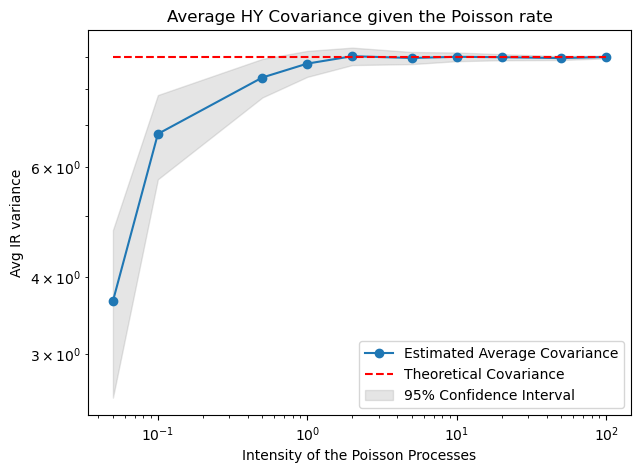

In [11]:
avg_cov_list = []
ci_lower = []
ci_upper = []

for mu in mu_list:
    data = cov_estimates[mu]
    avg = np.mean(data)
    std = np.std(data)
    n = len(data)
    se = std / np.sqrt(n)
    avg_cov_list.append(avg)
    ci_lower.append(avg - 1.96 * se)
    ci_upper.append(avg + 1.96 * se)
    print(f'Mu: {mu} | Average Cov: {avg} | Std Cov: {std}')

theoretical = rho * sigmas[0] * sigmas[1] * max_time
print(f'Theoretical Cov: {theoretical}')

plt.figure(figsize=(7, 5))
plt.plot(mu_list, np.array(avg_cov_list), marker='o', 
         label='Estimated Average Covariance')
plt.plot(mu_list, [theoretical] * len(mu_list), 
            linestyle='--', color='red', label='Theoretical Covariance')
plt.fill_between(mu_list, ci_lower, ci_upper, 
                 color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Average HY Covariance given the Poisson rate')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Intensity of the Poisson Processes')
plt.ylabel('Avg IR variance')
plt.legend()
plt.show()

As expected, the more we increase the number of samples, the more accurate the results are.

Now, we will compare the results of the Hayashi-Yoshida estimator with the ones of the standard estimator. This standard estimator divides the time into equal intervals. Since there is no point exactly on the desired moments, we do a forward interpolation, that is, we will in time the values of the previous price.

In [12]:
def interpolate_time_series (df, Ts, tau, max_time):
    #df_full = df_full.interpolate(method='time', limit_direction='both')
    
    df_sim_time = df.sort_index().copy()
    df1_sim_time = df_sim_time.loc[Ts[0]]
    df2_sim_time = df_sim_time.loc[Ts[1]]
    
    df_sim_time.index = pd.to_datetime(
        df_sim_time.index, unit='s', origin='unix'
    )
    
    df1_sim_time.index = pd.to_datetime(
        df1_sim_time.index, unit='s', origin='unix'
    )
    df2_sim_time.index = pd.to_datetime(
        df2_sim_time.index, unit='s', origin='unix'
    )
    
    start_dt = df_sim_time.index.min()
    end_dt = start_dt + pd.Timedelta(seconds=max_time)
    new_index = pd.date_range(start=start_dt, end=end_dt, freq=f'{tau}s')        

    combined_index_1 = df1_sim_time.index.union(new_index)
    combined_index_2 = df2_sim_time.index.union(new_index)

    df_full_1 = df_sim_time.reindex(combined_index_1)
    df_full_2 = df_sim_time.reindex(combined_index_2)
    
    df_full_1 = df_full_1.ffill()
    df_full_2 = df_full_2.ffill()

    df_sim_interpolated_1 = df_full_1.loc[new_index]
    df_sim_interpolated_2 = df_full_2.loc[new_index]
    
    df_sim_interpolated = pd.DataFrame({
        'p1': df_sim_interpolated_1['p1'],
        'p2': df_sim_interpolated_2['p2']
    }, index=new_index)
    
    df_sim_interpolated.index = (
        df_sim_interpolated.index - pd.Timestamp("1970-01-01")).total_seconds()
    
    return df_sim_interpolated

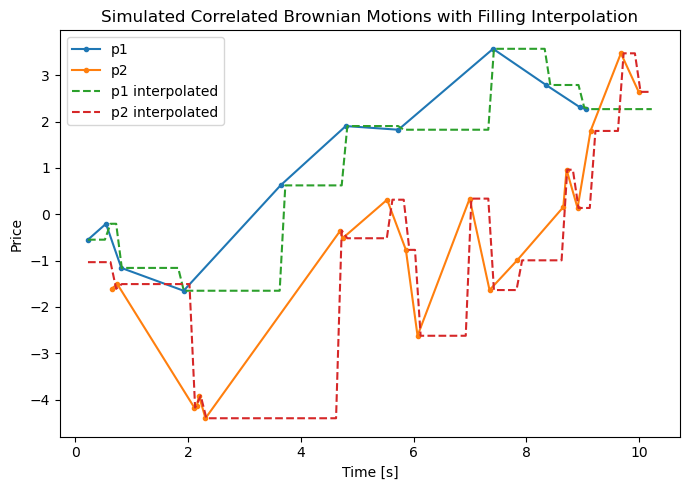

In [13]:
rho = 0.1
mu = [1, 2]
max_time = 10
sigmas = [1, 2]

T1 = time_homogeneous_poisson_process(mu[0], max_time)
T2 = time_homogeneous_poisson_process(mu[1], max_time)
df_simulation = simulated_correlated_BMs(rho, sigmas, [T1, T2])
df_interpolation = interpolate_time_series(
    df_simulation, [T1, T2], 0.1, max_time)

plt.figure(figsize=(7, 5))
plt.plot(df_simulation.loc[T1].index, df_simulation.loc[T1]['p1'], 
         label='p1', marker="o", markersize = 3)
plt.plot(df_simulation.loc[T2].index, df_simulation.loc[T2]['p2'], 
         label='p2', marker="o", markersize = 3)
plt.plot(df_interpolation.index, df_interpolation['p1'], 
         label='p1 interpolated', linestyle='--')
plt.plot(df_interpolation.index, df_interpolation['p2'], 
         label='p2 interpolated', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Price')
plt.legend()
plt.title('Simulated Correlated Brownian Motions with Filling Interpolation')
plt.tight_layout()
plt.show()

To get the standard estimator, we use the realized covariance estimator:

$$
RCov(p1, p2, \tau) = \sum^{floor(T / \tau)}_{i=1} ( p1(i \tau) - p1 ((i-1) \tau) ) * ( p2(i \tau) - p2 ((i-1) \tau) )
$$

Since the samples of the poisson process are not exactly on the desired moments, we will use the **forward interpolation**.

In [14]:
def standard_covariance_estimator (df_entry: pd.DataFrame = pd.DataFrame(),
                                   Ts: List[np.array] = [],
                                   tau : float = None, 
                                   max_time : float = -1) -> float:
    
    try:
        if df_entry.empty:
            raise ValueError("DataFrame is empty.")
        
        df = df_entry.copy()
        
        df_interpolation = interpolate_time_series(
            df, Ts, tau, max_time)
        
        dp1 = np.diff(df_interpolation.iloc[:, 0])
        dp2 = np.diff(df_interpolation.iloc[:, 1])
        
        cov_estimator = np.sum(dp1 * dp2)
        return cov_estimator
        
    except Exception as error:
        print(error)
        return None

In [15]:
N_sim = 100

rho = 0.5
mu = [4, 2]
max_time = 300
sigmas = [0.1, 0.3]

tau = 1

print(
    "Theoretical cov estimator", 
    round( rho * sigmas[0] * sigmas[1] * max_time, 2))

cov_estimates = []

for rep in range(N_sim):
    
    T1 = time_homogeneous_poisson_process(mu[0], max_time)
    T2 = time_homogeneous_poisson_process(mu[1], max_time)

    df_simulation = simulated_correlated_BMs(rho, sigmas, [T1, T2])

    cov_estimates.append(
        standard_covariance_estimator(
            df_simulation, [T1, T2], tau, max_time))
    
print("Estimated with standard covariance estimator \n",
      round(np.mean(cov_estimates), 3), "+-", 
      round(np.std(cov_estimates), 3))


Theoretical cov estimator 4.5
Estimated with standard covariance estimator 
 2.827 +- 0.541


In [16]:
N_sims = 100
tau_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cov_estimates_standard = {tau : [] for tau in tau_list}
cov_estimates_hy = []

rho = 0.5
mu = [10, 15]
max_time = 1000
sigmas = [0.5, 0.7]

print(
    "Theoretical cov estimator", 
    round( rho * sigmas[0] * sigmas[1] * max_time, 2))

for rep in range(N_sims):

    T1 = time_homogeneous_poisson_process(mu[0], max_time)
    T2 = time_homogeneous_poisson_process(mu[1], max_time)
    
    df_sim = simulated_correlated_BMs(rho, sigmas, [T1, T2])
    
    cov_estimates_hy.append(
        hayashi_yoshida_cov_estimator_optimized(df_sim, [T1, T2]))
    
    for tau in tau_list:        
        
        rcov = standard_covariance_estimator(
            df_sim, [T1, T2], tau, max_time)
        cov_estimates_standard[tau].append(rcov)
        
for tau in tau_list:
    avg = np.mean(cov_estimates_standard[tau])
    std = np.std(cov_estimates_standard[tau])
    n = len(cov_estimates_standard[tau])
    se = std / np.sqrt(n)
    cov_estimates_standard[tau] = (avg, std, se)
    print(f'Tau: {tau} | Average Cov: {avg} | Std Cov: {std}')

Theoretical cov estimator 175.0
Tau: 1 | Average Cov: 159.72900799733182 | Std Cov: 11.11838593163142
Tau: 2 | Average Cov: 166.67986199332933 | Std Cov: 14.826484240932526
Tau: 3 | Average Cov: 167.97665493112433 | Std Cov: 21.342953685162342
Tau: 4 | Average Cov: 170.62951224979642 | Std Cov: 19.716831171045293
Tau: 5 | Average Cov: 172.22981049809806 | Std Cov: 26.109853851734094
Tau: 6 | Average Cov: 170.18232354162305 | Std Cov: 28.924678191153976
Tau: 7 | Average Cov: 170.20450440855845 | Std Cov: 31.609653557516708
Tau: 8 | Average Cov: 172.97327266878648 | Std Cov: 33.910989445202034
Tau: 9 | Average Cov: 172.48974778409803 | Std Cov: 36.76957835715126
Tau: 10 | Average Cov: 168.89992203932587 | Std Cov: 37.61080044024925


Theoretical cov estimator 17.5
Tau: 1 | Average Cov: 15.847334682671187 | Std Cov: 3.837099731761782
Tau: 2 | Average Cov: 16.162898298585315 | Std Cov: 5.409736444312125
Tau: 3 | Average Cov: 15.93450069328858 | Std Cov: 6.8342179810174315
Tau: 4 | Average Cov: 15.822243091709383 | Std Cov: 7.762410225769927
Tau: 5 | Average Cov: 16.21396791385644 | Std Cov: 8.929876553601401
Tau: 6 | Average Cov: 14.785433622714663 | Std Cov: 9.230440147032152
Tau: 7 | Average Cov: 15.664487453240536 | Std Cov: 10.27571951709148
Tau: 8 | Average Cov: 15.645363920686655 | Std Cov: 10.3859301593506
Tau: 9 | Average Cov: 15.361565959268127 | Std Cov: 11.635865125900848
Tau: 10 | Average Cov: 16.243027440278404 | Std Cov: 11.661134074622614
Theoretical Cov: 17.5


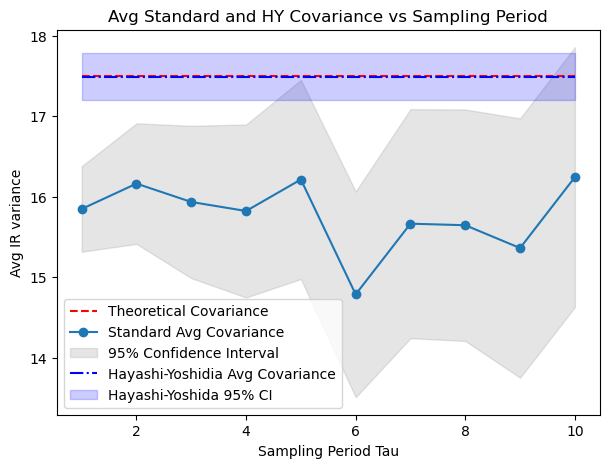

In [18]:
N_sims = 200
tau_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cov_estimates_standard = {tau : [] for tau in tau_list}
cov_estimates_hy = []

rho = 0.5
mu = [10, 15]
max_time = 100
sigmas = [0.5, 0.7]

print(
    "Theoretical cov estimator", 
    round( rho * sigmas[0] * sigmas[1] * max_time, 2))

for rep in range(N_sims):

    T1 = time_homogeneous_poisson_process(mu[0], max_time)
    T2 = time_homogeneous_poisson_process(mu[1], max_time)
    
    df_sim = simulated_correlated_BMs(rho, sigmas, [T1, T2])
    
    cov_estimates_hy.append(
        hayashi_yoshida_cov_estimator_optimized(df_sim, [T1, T2]))
    
    for tau in tau_list:        
        
        rcov = standard_covariance_estimator(
            df_sim, [T1, T2], tau, max_time)
        cov_estimates_standard[tau].append(rcov)


avg_cov_list = []
ci_lower = []
ci_upper = []

for tau in tau_list:
    data = cov_estimates_standard[tau]
    avg = np.mean(data)
    std = np.std(data)
    n = len(data)
    se = std / np.sqrt(n)
    avg_cov_list.append(avg)
    ci_lower.append(avg - 1.96 * se)
    ci_upper.append(avg + 1.96 * se)
    print(f'Tau: {tau} | Average Cov: {avg} | Std Cov: {std}')
    
hy_avg = np.mean(cov_estimates_hy)
hy_std = np.std(cov_estimates_hy)
n_hy = len(cov_estimates_hy)
hy_se = hy_std / np.sqrt(n_hy)
hy_ci_lower = hy_avg - 1.96 * hy_se
hy_ci_upper = hy_avg + 1.96 * hy_se
    
theoretical = round( rho * sigmas[0] * sigmas[1] * max_time, 2)
print(f'Theoretical Cov: {theoretical}')


plt.figure(figsize=(7, 5))
plt.plot(tau_list, [theoretical] * len(tau_list), 
            linestyle='--', color='red', label='Theoretical Covariance')
plt.plot(tau_list, np.array(avg_cov_list), marker='o', 
         label='Standard Avg Covariance')
plt.fill_between(tau_list, ci_lower, ci_upper, 
                 color='gray', alpha=0.2, label='95% Confidence Interval')
plt.plot(tau_list, [hy_avg]*len(tau_list), linestyle='-.', color='blue', 
         label='Hayashi-Yoshidia Avg Covariance')
plt.fill_between(tau_list, [hy_ci_lower]*len(tau_list), 
                 [hy_ci_upper]*len(tau_list), color='blue', alpha=0.2, 
                 label='Hayashi-Yoshida 95% CI')

plt.title('Avg Standard and HY Covariance vs Sampling Period')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Avg IR variance')
plt.legend()
plt.show()

We can clearly see that HY estimator converges to the theoretical value, while the standard estimator might do, we cannot a priori which sampling period is the best fit. 

## 2 - Signature plots and Epps effect

On your dataset, estimate the integrated realized variances for each stock and the correlation between the two stocks using the standard estimators and the Hayashi-Yoshida estimators.  Comment.

### SG Data

In [19]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

files = get_all_files(os.path.join('Data', 'SG'))

dfs = []

"""
for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('Data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    if i == 1:
        break  # < ----------------- remove this line to read all files
"""


df_sg = pd.read_csv(os.path.join('Data', 'SG', 'SG_20170123.csv.gz'), index_col = 0)
df_sg['ets'] = pd.to_datetime(df_sg['ets'], format='%Y%m%d:%H:%M:%S.%f')
df_sg = df_sg.sort_values(by='ets')
df_sg = df_sg.set_index('ets')
df_sg.head()

,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
ets,,,,,,,,
2017-01-23 09:00:12.026272,A,45260,420,S,45255,35,45260,420
2017-01-23 09:00:12.434171,A,45220,1132,S,45205,305,45220,1132
2017-01-23 09:01:00.028755,A,44800,16107,B,45175,463,45235,579
2017-01-23 09:01:00.028798,A,45560,16107,S,45175,463,45235,579
2017-01-23 09:01:00.056223,C,45105,286,B,45175,463,45235,579


In [20]:
df_trades_sg = df_sg[df_sg['etype'] == 'T'][['eprice']].copy()
df_trades_sg.shape

(14484, 1)

(14484, 3)


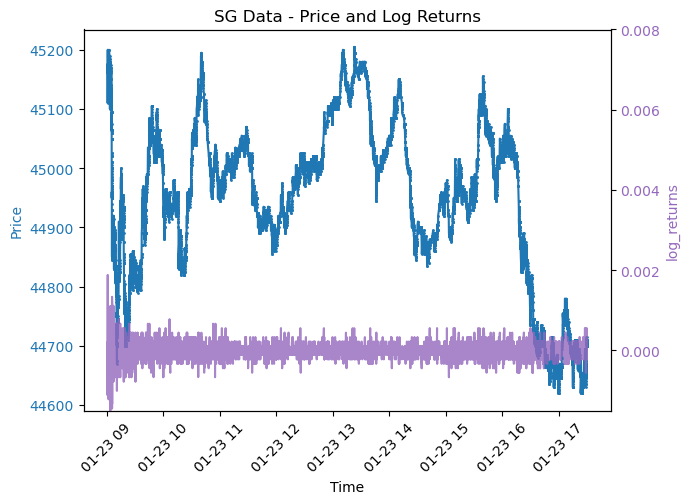

In [21]:
df_trades_sg['returns'] = df_trades_sg['eprice'].pct_change()
df_trades_sg['log_returns'] = np.log(df_trades_sg['eprice'])
df_trades_sg['log_returns'] = df_trades_sg['log_returns'].diff()
df_sg_to_plot = df_trades_sg[df_trades_sg.index < '2017-01-23 19:00:00']
print(df_sg_to_plot.shape)

fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.plot(df_sg_to_plot.index, df_sg_to_plot['eprice'],
         label='Price', marker="o", markersize = 1)
ax1.set_xlabel('Time')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df_sg_to_plot.index, df_sg_to_plot['log_returns'], alpha=0.8,
         label='log_returns', color='tab:purple')
ax2.set_ylabel('log_returns', color='tab:purple', )
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.set_ylim(-0.0015, 0.008)


fig.tight_layout()
plt.title('SG Data - Price and Log Returns')
plt.show()


In [22]:
test_stat, p_value, _, _ = het_arch(
    df_sg_to_plot['log_returns'].dropna(), nlags = 50)

print("ARCH Test Statistic:", test_stat)
print("p-value:", p_value)

ARCH Test Statistic: 851.172091475874
p-value: 3.1511181181298883e-146


In brownian motion simulation work frame, the log returns are to follow a normal distribution with constant volatility. However, we can see from the graph and the ARCH test that the variance is not constant. This is important, because if we want to check realized integrated covariance, we must consider the fact that the volatility is not constant. In other words, we must be careful with the sampling time length. Between different days the volatility might differ and even between hours in the same day.

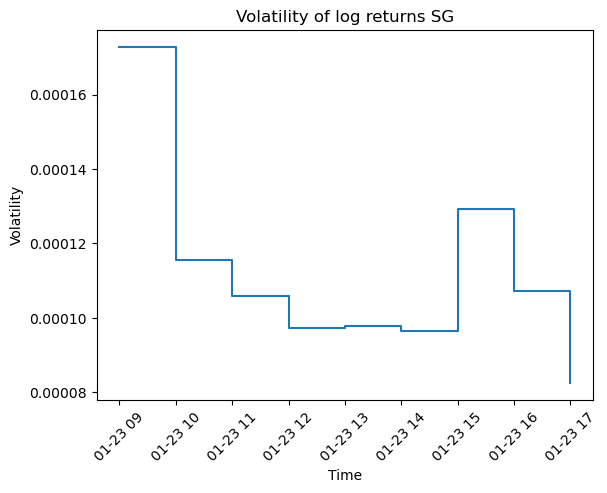

In [23]:
volatilites = (
    df_sg_to_plot['log_returns']
    .dropna()
    .groupby(pd.Grouper(freq='1h'))
    .std()
)

plt.step(volatilites.index, volatilites.values, where='post')
plt.title('Volatility of log returns SG')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.show()

L'hypothèse du modèle est que la volatilité des browniens est constante, or nous pouvons clairement attester par ce graphe qu'elle ne l'est pas.

### BNP data

In [24]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

files = get_all_files(os.path.join('Data', 'SG'))

dfs = []

"""
for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('Data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    if i == 1:
        break  # < ----------------- remove this line to read all files
"""

df_bnp = pd.read_csv(os.path.join('Data', 'BNPP', 'BNPP_20170123.csv.gz'), index_col = 0)
df_bnp['ets'] = pd.to_datetime(df_bnp['ets'], format='%Y%m%d:%H:%M:%S.%f')
df_bnp = df_bnp.sort_values(by='ets')
df_bnp = df_bnp.set_index('ets')
df_bnp.head()

,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
ets,,,,,,,,
2017-01-23 09:00:12.431521,A,59490,1326,S,59470,2051,59490,1326
2017-01-23 09:00:34.788784,A,59360,7415,S,59350,370,59360,7415
2017-01-23 09:00:51.215264,A,59370,251,B,59370,251,59380,200
2017-01-23 09:01:00.012317,A,58890,19667,B,59400,408,59440,127
2017-01-23 09:01:00.012398,A,59880,19667,S,59400,408,59440,127


In [25]:
df_trades_bnp = df_bnp[df_bnp['etype'] == 'T'][['eprice']].copy()
df_trades_bnp.shape

(9974, 1)

(9974, 3)


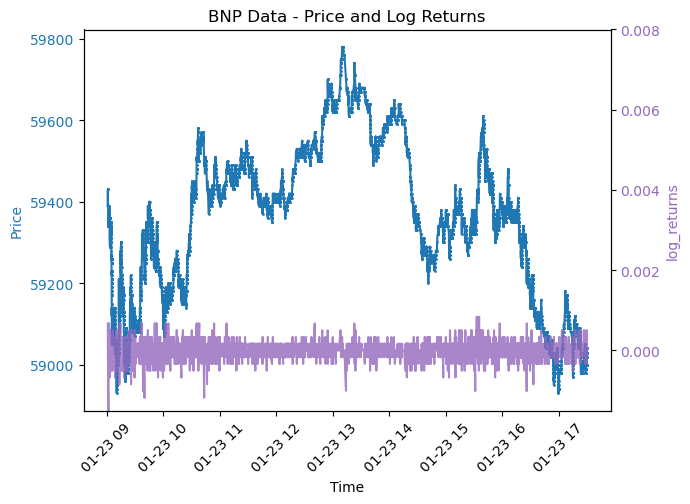

In [26]:
df_trades_bnp['returns'] = df_trades_bnp['eprice'].pct_change()
df_trades_bnp['log_returns'] = np.log(df_trades_bnp['eprice'])
df_trades_bnp['log_returns'] = df_trades_bnp['log_returns'].diff()
df_bnp_to_plot = df_trades_bnp[df_trades_bnp.index < '2017-01-23 19:00:00']
print(df_bnp_to_plot.shape)

fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.plot(df_bnp_to_plot.index, df_bnp_to_plot['eprice'],
         label='Price', marker="o", markersize = 1)
ax1.set_xlabel('Time')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df_bnp_to_plot.index, df_bnp_to_plot['log_returns'], alpha=0.8,
         label='log_returns', color='tab:purple')
ax2.set_ylabel('log_returns', color='tab:purple', )
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.set_ylim(-0.0015, 0.008)


fig.tight_layout()
plt.title('BNP Data - Price and Log Returns')
plt.show()


In [27]:
test_stat, p_value, _, _ = het_arch(
    df_bnp_to_plot['log_returns'].dropna(), nlags = 50)

print("ARCH Test Statistic:", test_stat)
print("p-value:", p_value)

ARCH Test Statistic: 152.50295801171208
p-value: 2.668072539134658e-12


Same result for the volatility. It is not constant. (Specially at the beginning)

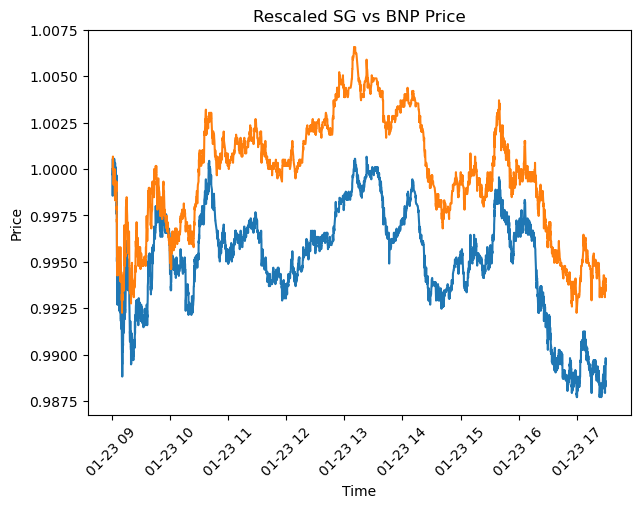

In [28]:
plt.figure(figsize=(7, 5))

plt.plot(df_sg_to_plot.index, 
         df_sg_to_plot['eprice'] / df_sg_to_plot['eprice'].iloc[0], 
         label="SG")
plt.plot(df_bnp_to_plot.index, 
         df_bnp_to_plot['eprice'] / df_bnp_to_plot['eprice'].iloc[0], 
         label="BNP")
plt.title('Rescaled SG vs BNP Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

We can see from the graph that both time series are highly correlated. Therefore, we should expect a $\rho$ higher than 0.5.

### Integrated variance

#### Standard estimator

To get the standard estimator, we use the realized variance estimator:

$$
RV(\tau) = \sum^{floor(T / \tau)}_{i=1} ( p(i \tau) - p((i-1) \tau) )^2
$$


In [29]:
def interpolate_time_serie (df_input, tau, start_dt, end_dt):
    #df_full = df_full.interpolate(method='time', limit_direction='both')
    
    df = df_input.sort_index().copy()
    df = df.loc[df.index < end_dt]
    df = df.loc[df.index > start_dt]
    
    df.index = pd.to_datetime(
        df.index, unit='s', origin='unix'
    )
    
    new_index = pd.date_range(start=start_dt, end=end_dt, freq=f'{tau}s')        

    combined_index = df.index.union(new_index)

    df_full = df.reindex(combined_index)
    df_full = df_full.ffill()
    df_full = df_full.bfill()

    df_interpolated = df_full.loc[new_index]
    
    df_interpolated = pd.DataFrame({
        'price': df_interpolated.iloc[:, 0],
    }, index=new_index)

    return df_interpolated

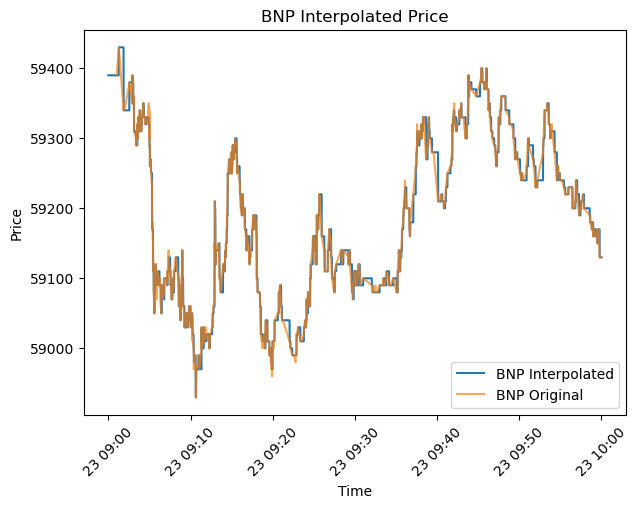

In [30]:
start_dt = pd.Timestamp(2017, 1, 23, 9, 0, 0)
end_dt = pd.Timestamp(2017, 1, 23, 18, 0, 0)


start_dt_plot = pd.Timestamp(2017, 1, 23, 9, 0, 0)
time_window = pd.Timedelta(hours=1)
end_dt_plot = start_dt_plot + time_window

df_bnp_interpolated = interpolate_time_serie(df_trades_bnp[['eprice']]
                                             , 1, start_dt, end_dt)
df_bnp_interpolated = df_bnp_interpolated.loc[start_dt_plot:end_dt_plot]
df_temp = df_trades_bnp.loc[start_dt_plot:end_dt_plot]

plt.figure(figsize=(7, 5))
plt.plot(df_bnp_interpolated, 
         label='BNP Interpolated')
plt.plot(df_temp.index, df_temp['eprice'], 
         label='BNP Original', alpha=0.7)
plt.title('BNP Interpolated Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

In [68]:
def realized_variance_estimator_resample(
    df_entry: pd.DataFrame = pd.DataFrame(),
    tau: int = None,  # tau in seconds
    start_dt: pd.Timestamp = None,
    end_dt: pd.Timestamp = None,
    log_prices: bool = True,
) -> float:
    try:
        if df_entry.empty:
            raise ValueError("DataFrame is empty.")

        df = df_entry.copy()
        
        # Filter by date range
        if start_dt:
            df = df[df.index >= start_dt]
        if end_dt:
            df = df[df.index <= end_dt]

        if tau is None:
            raise ValueError("Tau must be specified in seconds.")
        
        # Convert tau to a pandas-compatible resampling string (e.g., '5s')
        tau_str = f'{tau}s'
        
        if log_prices:
            # Convert prices to log-prices
            df = np.log(df)
        df_resampled = df.resample(tau_str).last().dropna()

        log_prices = df_resampled.iloc[:, 0].values
        log_returns = np.diff(log_prices)

        rv = np.sum(log_returns ** 2)
        return rv

    except Exception as error:
        print(f"Error: {error}")
        return None



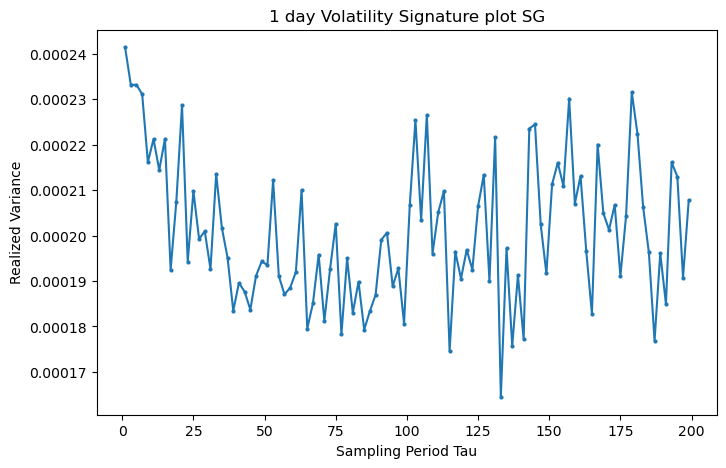

In [69]:
start_dt = pd.Timestamp(2017, 1, 23, 9, 1, 0)
end_dt = pd.Timestamp(2017, 1, 23, 17, 59, 0)
T = (end_dt - start_dt).total_seconds()


realized_variance_list = []
tau_list = list(range(1, 200, 2))
for tau in tau_list:
    realized_variance_list.append(
        realized_variance_estimator_resample(
            df_trades_sg[['eprice']], tau, start_dt, end_dt))

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list, marker='o', markersize=2)
plt.title('1 day Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.show()

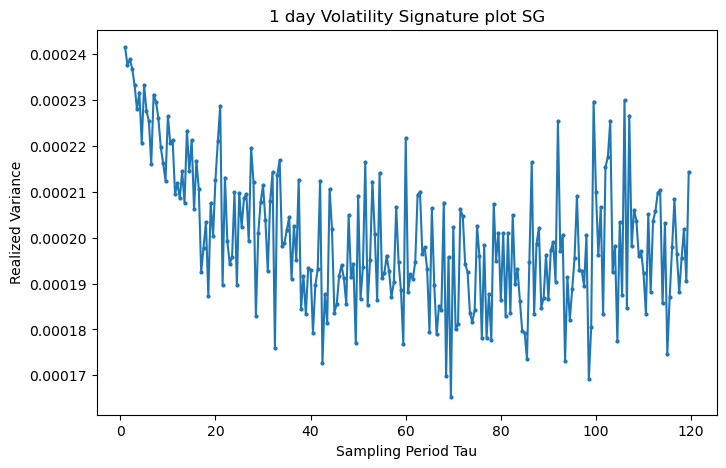

In [70]:
realized_variance_list = []
tau_list = list(np.arange(1, 120, 0.5))

for tau in tau_list:
    realized_variance_list.append(
        realized_variance_estimator_resample(
            df_trades_sg[['eprice']], tau, start_dt, end_dt))

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list, marker='o', markersize=2)
plt.title('1 day Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.show()

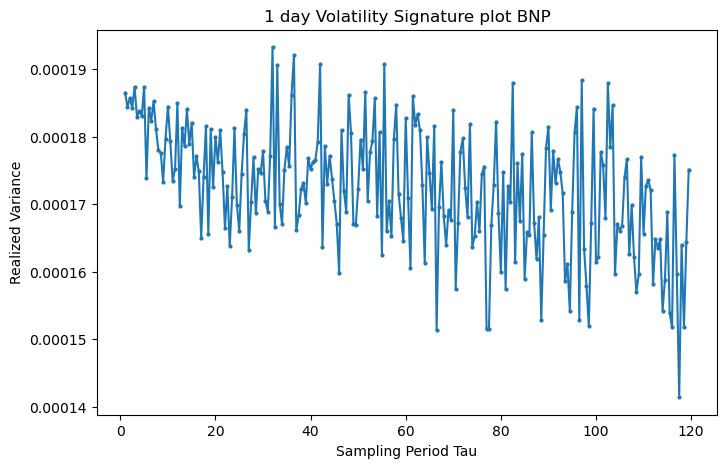

In [71]:
realized_variance_list = []
#tau_list = list(range(1, 200, 2))
tau_list = list(np.arange(1, 120, 0.5))

for tau in tau_list:
    realized_variance_list.append(
        realized_variance_estimator_resample(
            df_trades_bnp[['eprice']], tau, start_dt, end_dt))

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list, marker='o', markersize=2)
plt.title('1 day Volatility Signature plot BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.show()

Interpretation : On this specific day, the signatures plots looks like they are corresponding to the theory, but we managed to have reversed signature plots for the 17th day of the datasets for BNPP, maybe due to a special event on that day, or just a noisy day.

#### Hayashi-yoshida estimator

In [72]:
def hayashi_yoshida_variance_estimator_for_prices(
                                    df_entry: pd.DataFrame = pd.DataFrame(),
                                    start_dt : pd.Timestamp = None,
                                    end_dt : pd.Timestamp = None) -> float:
    
    # We will assume that df_entry is already in the
    # Log price format.
    
    try:
        if df_entry.empty:
            raise ValueError("DataFrame is empty.")
        
        df = df_entry.copy()   
        df = df.loc[start_dt:end_dt]   
        df = df.sort_index()  
        
        log_prices = df.iloc[:, 0].values
        log_returns = np.diff(log_prices)
  
        i, j = 0, 0
        variance_estimator = 0.0
        n1 = len(df.index) - 1  
        n2 = len(df.index) - 1  

        # Loop until one set of intervals is fully processed
        while i < n1 and j < n2:
            
            startI, endI = df.index[i], df.index[i+1]
            startJ, endJ = df.index[j], df.index[j+1]
            
            # Check for no overlap:
            if endI <= startJ:
                # i-th interval ends before j-th interval starts
                i += 1
            elif endJ <= startI:
                # j-th interval ends before i-th interval starts
                j += 1
            else:
                # Intervals overlap, so add product of increments
                variance_estimator += log_returns[i] * log_returns[j]
                
                # Advance pointer for the interval that ends first
                if endI < endJ:
                    i += 1
                elif endJ < endI:
                    j += 1
                else:
                    # If both end simultaneously, advance both pointers
                    i += 1
                    j += 1
        
        return variance_estimator

    except Exception as e:
        print(f"Error: {e}")
        return 0.0
        
    except Exception as error:
        print(error)
        return None

In [73]:

value = hayashi_yoshida_variance_estimator_for_prices(
    np.log(df_trades_sg[['eprice']]), start_dt, end_dt)

print("Hayashi - Yoshida variance :", float(round(value, 5)))

Hayashi - Yoshida variance : 0.00022


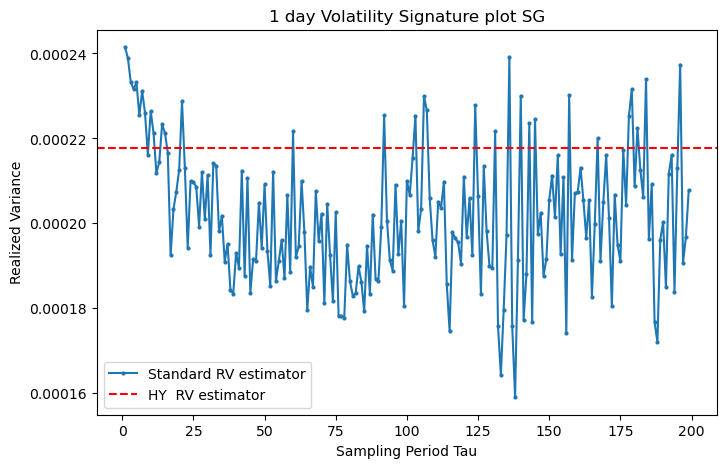

In [74]:
realized_variance_list = []
#tau_list = list(range(1, 200, 2))
tau_list = list(np.arange(1, 200, 1))
for tau in tau_list:
    realized_variance_list.append(
        realized_variance_estimator_resample(
            df_trades_sg[['eprice']], tau, start_dt, end_dt))
    
hy_variance = hayashi_yoshida_variance_estimator_for_prices(
    np.log(df_trades_sg[['eprice']]), start_dt, end_dt)

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.axhline(y=hy_variance, color='r', linestyle='--', 
            label='HY  RV estimator')
plt.title('1 day Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

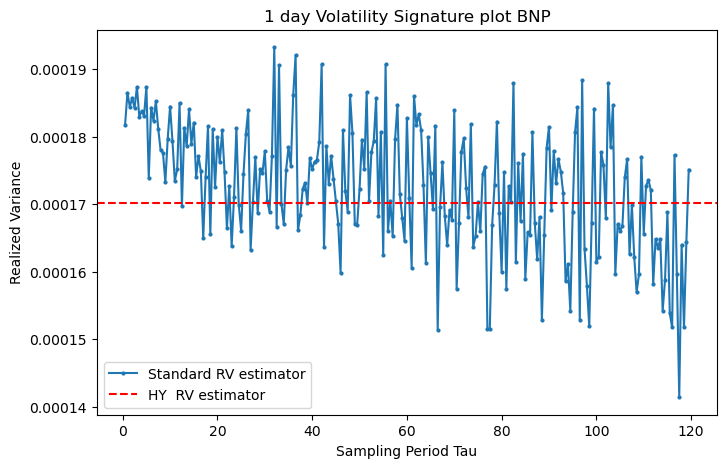

In [75]:

realized_variance_list = []
#tau_list = list(range(1, 200, 2))
tau_list = list(np.arange(0.5, 120, 0.5))

for tau in tau_list:
    realized_variance_list.append(
        realized_variance_estimator_resample(
            df_trades_bnp[['eprice']], tau, start_dt, end_dt))
    
hy_variance = hayashi_yoshida_variance_estimator_for_prices(
    np.log(df_trades_bnp[['eprice']]), start_dt, end_dt)

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.axhline(y=hy_variance, color='r', linestyle='--', 
            label='HY  RV estimator')
plt.title('1 day Volatility Signature plot BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

For the SG data, we can see that the results are very similar, since the follow the same pattern than the one studied during the curse. However, for the BNP data, instead of decreaseing the realized variance, it increases when we increase the step size.

### Correlation 

To get the correlation, we can use the following formula:

$$
\rho_{HY} = \frac{ \sum_{i,j} \Delta P_1(I^i) \Delta P_2(J^j) \, \mathbf{1}\{I^i \cap J^j \neq \emptyset\} } { \sqrt{ \sum_{i} \Delta P_1(I^i)^2 } \sqrt{ \sum_{i} \Delta P_2(J^j)^2 } }
$$

In [76]:
def hayashi_yoshida_cov_estimator_for_prices(
                                    df_entry1: pd.DataFrame = pd.DataFrame(),
                                    df_entry2: pd.DataFrame = pd.DataFrame(),
                                    start_dt : pd.Timestamp = None,
                                    end_dt : pd.Timestamp = None) -> float:
    
    # We will assume that df_entry is already in the
    # Log price format.
    
    try:
        if df_entry1.empty or df_entry2.empty:
            raise ValueError("DataFrame is empty.")
        
        df1 = df_entry1.copy()   
        df1 = df1.loc[start_dt:end_dt]   
        df1 = df1.sort_index()
        
        df2 = df_entry2.copy()
        df2 = df2.loc[start_dt:end_dt]
        df2 = df2.sort_index()
        
        log_prices1 = df1.iloc[:, 0].values
        log_prices2 = df2.iloc[:, 0].values
        log_returns1 = np.diff(log_prices1)
        log_returns2 = np.diff(log_prices2)
  
        i, j = 0, 0
        variance_estimator = 0.0
        n1 = len(df1.index) - 1  
        n2 = len(df2.index) - 1  

        while i < n1 and j < n2:
            
            startI, endI = df1.index[i], df1.index[i+1]
            startJ, endJ = df2.index[j], df2.index[j+1]
            
            if endI <= startJ:
                i += 1
            elif endJ <= startI:
                j += 1
            else:
                variance_estimator += log_returns1[i] * log_returns2[j]
                
                if endI < endJ:
                    i += 1
                elif endJ < endI:
                    j += 1
                else:
                    i += 1
                    j += 1
        
        return variance_estimator

    except Exception as e:
        print(f"Error: {e}")
        return 0.0
        
    except Exception as error:
        print(error)
        return None

In [77]:
hy_cov = hayashi_yoshida_cov_estimator_for_prices(
    np.log(df_trades_sg[['eprice']]), 
    np.log(df_trades_bnp[['eprice']]), 
    start_dt, end_dt
)

hy_variance_sg = hayashi_yoshida_variance_estimator_for_prices(
    np.log(df_trades_sg[['eprice']]), start_dt, end_dt)
hy_variance_bnp = hayashi_yoshida_variance_estimator_for_prices(
    np.log(df_trades_bnp[['eprice']]), start_dt, end_dt)

print("Hayashi - Yoshida covariance :", float(round(hy_cov, 5)))
print("Hayashi - Yoshida variance SG :", float(round(hy_variance_sg, 5)))
print("Hayashi - Yoshida variance BNP :", float(round(hy_variance_bnp, 5)))

hv_corr = hy_cov / np.sqrt(hy_variance_sg * hy_variance_bnp)
print("Hayashi - Yoshida correlation :", float(round(hv_corr, 5)))

Hayashi - Yoshida covariance : 0.00011
Hayashi - Yoshida variance SG : 0.00022
Hayashi - Yoshida variance BNP : 0.00017
Hayashi - Yoshida correlation : 0.56066


In [78]:
def hayashi_yoshida_correlation (df_entry1 : pd.DataFrame = pd.DataFrame(),
                                 df_entry2 : pd.DataFrame = pd.DataFrame(),
                                 start_dt : pd.Timestamp = None,
                                 end_dt : pd.Timestamp = None,
                                 display : bool = False) -> float:
    
    # We assume that df_entry is already in the
    # Log price format.
    
    if df_entry1.empty or df_entry2.empty:
        raise ValueError("DataFrame is empty.")
    
    cov = hayashi_yoshida_cov_estimator_for_prices(
        df_entry1, df_entry2, start_dt, end_dt)
    var1 = hayashi_yoshida_variance_estimator_for_prices(
        df_entry1, start_dt, end_dt)
    var2 = hayashi_yoshida_variance_estimator_for_prices(
        df_entry2, start_dt, end_dt)
    
    corr = cov / np.sqrt(var1 * var2)
    
    if display:
        print("Hayashi-Yoshida correlation:")
        print("Covariance:", round(cov, 5))
        print("Variance 1:", round(var1, 5))
        print("Variance 2:", round(var2, 5))
        print("Correlation:", round(corr, 5))
    
    return corr       

In [79]:
hy_corr = hayashi_yoshida_correlation(
    np.log(df_trades_sg[['eprice']]), 
    np.log(df_trades_bnp[['eprice']]), 
    start_dt, end_dt, display = True
)

Hayashi-Yoshida correlation:
Covariance: 0.00011
Variance 1: 0.00022
Variance 2: 0.00017
Correlation: 0.56066


For the standard estimator of the correlation $\rho$, we can use the following formula:

$$
\rho_{standard} = \frac{ \displaystyle \sum^{floor(T / \tau)}_{i=1} ( p1(i \tau) - p1 ((i-1) \tau) ) * ( p2(i \tau) - p2 ((i-1) \tau) ) }
{ \sqrt{ \displaystyle \sum^{floor(T / \tau)}_{i=1} ( p1(i \tau) - p1 ((i-1) \tau) )^2 } \sqrt{ \displaystyle \sum^{floor(T / \tau)}_{i=1} ( p2(i \tau) - p2 ((i-1) \tau) )^2 } }
$$

In [80]:
def realized_cov_estimator_for_prices_resample(
    df_entry1: pd.DataFrame,
    df_entry2: pd.DataFrame,
    tau: float,
    start_dt: pd.Timestamp,
    end_dt: pd.Timestamp
) -> float:

    try:
        if df_entry1.empty or df_entry2.empty:
            raise ValueError("One or both DataFrames are empty.")
        
        # Trim to common date range
        df1 = df_entry1[start_dt:end_dt].copy()
        df2 = df_entry2[start_dt:end_dt].copy()
        
        # Convert to log prices
        df1['log_price'] = np.log(df1.iloc[:, 0])
        df2['log_price'] = np.log(df2.iloc[:, 0])
        
        # Resample at tau-second intervals
        tau_str = f'{int(tau)}s'
        df1_resampled = df1['log_price'].resample(tau_str).last().dropna()
        df2_resampled = df2['log_price'].resample(tau_str).last().dropna()
        
        # Align the two series (inner join on timestamps)
        df_joined = pd.concat([df1_resampled, df2_resampled], axis=1, join='inner').dropna()
        log_returns1 = np.diff(df_joined.iloc[:, 0])
        log_returns2 = np.diff(df_joined.iloc[:, 1])
        
        realized_cov = np.sum(log_returns1 * log_returns2)
        return realized_cov

    except Exception as error:
        print("Error in realized_cov_estimator_for_prices_resample:", error)
        return None


In [82]:
def realized_corr_estimator_for_prices_resample(
    df_entry1: pd.DataFrame,
    df_entry2: pd.DataFrame,
    tau: float,
    start_dt: pd.Timestamp,
    end_dt: pd.Timestamp
) -> float:

    try:
        cov_estimator = realized_cov_estimator_for_prices_resample(
            df_entry1, df_entry2, tau, start_dt, end_dt)
        
        var1 = realized_variance_estimator_resample(
            df_entry1, tau, start_dt, end_dt)
        var2 = realized_variance_estimator_resample(
            df_entry2, tau, start_dt, end_dt)
        
        if var1 <= 1e-12 or var2 <= 1e-12:
            return np.nan
        
        return cov_estimator / np.sqrt(var1 * var2)

    except Exception as error:
        print("Error in realized_corr_estimator_for_prices_resample:", error)
        return None

In [83]:
tau = 1

corr = realized_corr_estimator_for_prices_resample(
    df_trades_sg[['eprice']], 
    df_trades_bnp[['eprice']], 
    tau, start_dt, end_dt)

print(f"Realized correlation with tau {tau} :", round(corr, 5))

Realized correlation with tau 1 : 0.57684


In [84]:
taus = list(np.arange(1, 200, 1))
realized_corr_estimates = []

for tau in taus:
    realized_corr_estimates.append(
        realized_corr_estimator_for_prices_resample(
            np.log(df_trades_sg[['eprice']]), 
            np.log(df_trades_bnp[['eprice']]), 
            tau, start_dt, end_dt))

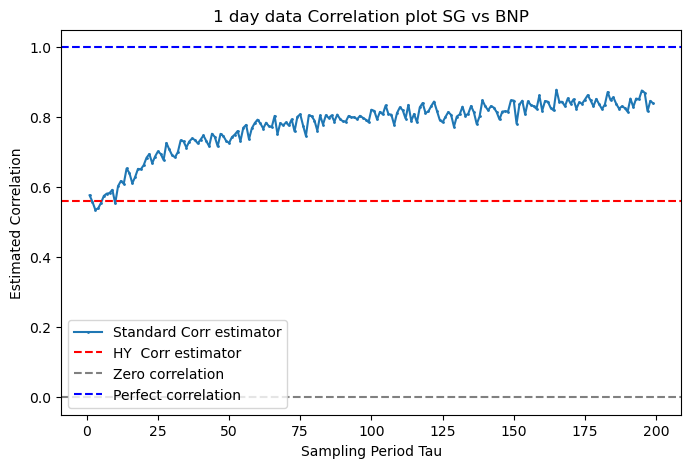

In [85]:
plt.figure(figsize=(8, 5))
plt.plot(taus, realized_corr_estimates, marker='o', markersize=1,
         label ='Standard Corr estimator')
plt.axhline(y=hv_corr, color='r', linestyle='--', 
            label='HY  Corr estimator')
plt.axhline(y=0, color='gray', linestyle='--',
            label='Zero correlation')
plt.axhline(y=1, color='blue', linestyle='--',
            label='Perfect correlation')

plt.title('1 day data Correlation plot SG vs BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Estimated Correlation')
plt.legend()
plt.show()

We can clearly appreciate the Epps effect. The higher the time step, the higher the correlation. However, we can note that after a certain time step, the correlation is higher than the one estimated with the Hayashi-Yoshida estimator. Therefore, we cannot conclude that the standard estimator is correctly converging to the theoretical value without saying that the Hayashi-Yoshida estimator is wrong.

## 3 - Hawkes fit on signature plots

Fit the single stock Hawkes model of [1] on the signature plot for each stock of your dataset.  Comment.  Simulate the model with the calibrated parameter values and plot the empirical, fitted and simulated signature plots.

### Fit the single stock Hawkes model

The theoretical model's formulation is given by:

$$
C(\tau) = \Lambda (\kappa^2 + (1- \kappa^2) \frac{1 - e^{-\gamma \tau}}{\gamma \tau})
$$

Where:

- $\Lambda = \frac{2 \lambda_0}{a - \frac{\alpha}{\beta}}$
- $\kappa = \frac{1}{1 + \frac{\alpha}{\beta}}$
- $\gamma = \alpha + \beta$

The parameters to estimate are: $\lambda_0$, $\alpha$ and $\beta$.

To do so, we can use a non-linear least squares method. We can use the `curve_fit` function from `scipy.optimize` to do so.

In [86]:
def kappa (alpha, beta):
    return 1 / (1 + alpha / beta)
def Lambda (lambda_0, alpha, beta):
    return 2 * lambda_0 / (1 - alpha / beta)
def gamma (alpha, beta):
    return alpha + beta

def mean_signature_hawks (tau, alpha, beta, lambda_0):
    k = kappa(alpha, beta)
    L = Lambda(lambda_0, alpha, beta)
    g = gamma(alpha, beta)
    
    return L * (k ** 2 + ( 1 - k ** 2) * (1 - np.exp(-g * tau)) / (g * tau)) 

T: 32280.0
Estimated parameters:
alpha: 1.4935992363248822
beta: 3.5656497248537806
lambda_0: 0.00011693379646587843


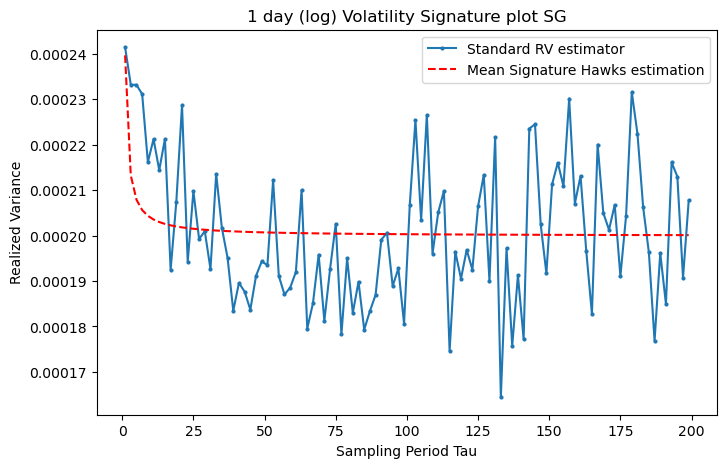

In [87]:
T = (end_dt - start_dt).total_seconds()
print("T:", T)

tau_list = list(range(1, 200, 2))
realized_variance_list = []
for tau in tau_list:
    realized_variance_list.append(
        realized_variance_estimator_resample(
            df_trades_sg[['eprice']], tau, start_dt, end_dt) )


# Fit the mean signature function to the data
popt, pcov = curve_fit(
    mean_signature_hawks, tau_list, realized_variance_list,
    p0=[0.5, 0.8, 1], bounds=([0, 0, 1e-5], [5, 5, 1]))
alpha_sg, beta_sg, lambda_0_sg = popt
print("Estimated parameters:")
print("alpha:", alpha_sg)
print("beta:", beta_sg)
print("lambda_0:", lambda_0_sg)

# Plot the fitted curve
plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_sg, beta_sg, lambda_0_sg), linestyle='--', color='red',
         label='Mean Signature Hawks estimation')
plt.title('1 day (log) Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

We were able to fit the model with the `curve_fit` function, yet we can see that the constant parameter of the hawkes process is very low, which is not realistic.

In [88]:
T = (end_dt - start_dt).total_seconds()
print("T:", T)

tau_list = list(range(1, 200, 2))
realized_variance_list = []
for tau in tau_list:
    realized_variance_list.append(
        realized_variance_estimator_resample(
            df_trades_bnp[['eprice']], tau, start_dt, end_dt))

T: 32280.0


Estimated parameters:
alpha: 0.08413807976015322
beta: 0.619616293951727
lambda_0: 9.243026694378466e-05


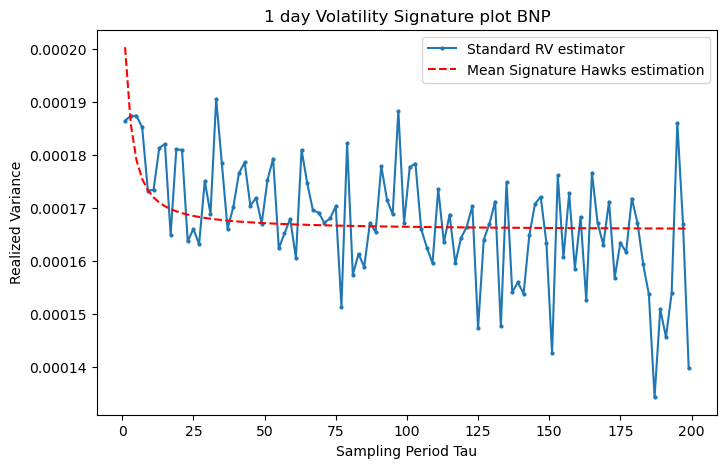

In [89]:
popt, pcov = curve_fit(
    mean_signature_hawks, tau_list, realized_variance_list,
    p0=[0.5, 0.8, 1], bounds=([0, 0, 1e-5], [1, 1, 10]))
alpha_bnp, beta_bnp, lambda_0_bnp = popt
print("Estimated parameters:")
print("alpha:", alpha_bnp)
print("beta:", beta_bnp)
print("lambda_0:", lambda_0_bnp)

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_bnp, beta_bnp, lambda_0_bnp), linestyle='--', color='red',
         label='Mean Signature Hawks estimation')
plt.title('1 day Volatility Signature plot BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

Again, the constant parameter of the hawkes process is very low.

### Testing cross-excitation Hawks simulation model

In [90]:
def Hawkes_Thinning_Bivariate(
    T,            
    lambda_0,    
    alpha,        
    beta,         
    seed=42,
    verbose=False
):

    rng = np.random.default_rng(seed)

    events1 = []
    events2 = []


    t = 0.0

    def lambda1(t_current):

        if len(events2) == 0:
            return lambda_0
        return lambda_0 + alpha * np.sum(
            np.exp(-beta * (t_current - np.array(events2)))
        )

    def lambda2(t_current):
        if len(events1) == 0:
            return lambda_0
        return lambda_0 + alpha * np.sum(
            np.exp(-beta * (t_current - np.array(events1)))
        )

    while True:
        lam1_t = lambda1(t)
        lam2_t = lambda2(t)
        lam_sum_t = lam1_t + lam2_t
        
        if lam_sum_t <= 0:
            if verbose:
                print("La intensidad total es 0. Terminando simulación.")
            break

        
        dt = rng.exponential(1.0 / lam_sum_t)
        t_candidate = t + dt

        # Si el siguiente evento excede T, paramos
        if t_candidate > T:
            break

        # Recalculamos intensidades en el candidato
        lam1_cand = lambda1(t_candidate)
        lam2_cand = lambda2(t_candidate)
        lam_sum_cand = lam1_cand + lam2_cand

        u = rng.uniform(0, 1)
        if u < lam_sum_cand / lam_sum_t:
            v = rng.uniform(0, 1)
            if v < lam1_cand / lam_sum_cand:
                events1.append(t_candidate)
                if verbose:
                    print(f"Evento en N1 a t={t_candidate:.4f}")
            else:
                events2.append(t_candidate)
                if verbose:
                    print(f"Evento en N2 a t={t_candidate:.4f}")

        t = t_candidate

        if verbose and t < T:
            print(f"t={t:.4f}, lam1={lam1_cand:.4f}, lam2={lam2_cand:.4f}, total={lam_sum_cand:.4f}")

    return np.array(events1), np.array(events2)

In [91]:
def Hawkes_Thinning_Bivariate_Optimized(T, lambda_0, 
                                        alpha, beta, seed=42, verbose=False):

    rng = np.random.default_rng(seed)

    events1 = []
    events2 = []

    
    A1 = 0.0  # Acumulate events
    A2 = 0.0  # Acumulate events

    t = 0.0

    while True:
        lam1 = lambda_0 + alpha * A1
        lam2 = lambda_0 + alpha * A2
        lam_sum = lam1 + lam2

        if lam_sum <= 0:
            if verbose:
                print("The total intensity is 0. Ending simulation.")
            break

        dt = rng.exponential(1.0 / lam_sum)
        t_candidate = t + dt

        if t_candidate > T:
            break

        decay = np.exp(-beta * (t_candidate - t))
        A1 *= decay
        A2 *= decay

        lam1_cand = lambda_0 + alpha * A1
        lam2_cand = lambda_0 + alpha * A2
        lam_sum_cand = lam1_cand + lam2_cand

        u = rng.uniform()
        if u < lam_sum_cand / lam_sum:
            v = rng.uniform()
            if v < lam1_cand / lam_sum_cand:
                events1.append(t_candidate)
                A2 += 1.0 
                if verbose:
                    print(f"Evento en N1 a t={t_candidate:.4f}")
            else:

                events2.append(t_candidate)
                A1 += 1.0  
                if verbose:
                    print(f"Evento en N2 a t={t_candidate:.4f}")

        t = t_candidate

        if verbose and t < T:
            print(f"t={t:.4f}, lam1_cand={lam1_cand:.4f},",
                  f"lam2_cand={lam2_cand:.4f}, total={lam_sum_cand:.4f}")

    return np.array(events1), np.array(events2)

In [92]:
T = 100.0
lambda_0 = 0.5
alpha = 0.8
beta = 1.0

ev1, ev2 = Hawkes_Thinning_Bivariate_Optimized(T, lambda_0, alpha, beta, 
                                     seed=123, verbose=False)
print("\nResults:")
print(f"p(T) = N1(T) - N2(T) = {len(ev1)} - {len(ev2)} = {len(ev1)-len(ev2)}")


Results:
p(T) = N1(T) - N2(T) = 230 - 224 = 6


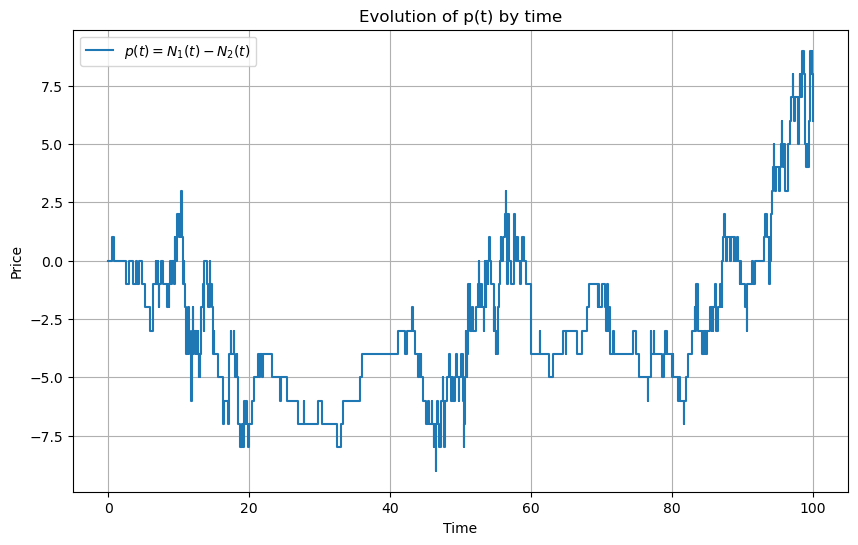

In [93]:
events = [(t, +1) for t in ev1] + [(t, -1) for t in ev2]
events.sort(key=lambda x: x[0])

times = [0]
prices = [0]
price = 0

for t_event, change in events:
    times.append(t_event)
    price += change
    prices.append(price)

if times[-1] < T:
    times.append(T)
    prices.append(price)

plt.figure(figsize=(10, 6))
plt.step(times, prices, where='post', label=r'$p(t)=N_1(t)-N_2(t)$')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Evolution of p(t) by time')
plt.grid(True)
plt.legend()
plt.show()

In [94]:
def plot_bivar_hawks (ev1, ev2, label = ""):
    events = [(t, +1) for t in ev1] + [(t, -1) for t in ev2]
    events.sort(key=lambda x: x[0])

    times = [0]
    prices = [0]
    price = 0

    for t_event, change in events:
        times.append(t_event)
        price += change
        prices.append(price)

    if times[-1] < T:
        times.append(T)
        prices.append(price)

    plt.step(times, prices, where='post', label=label)

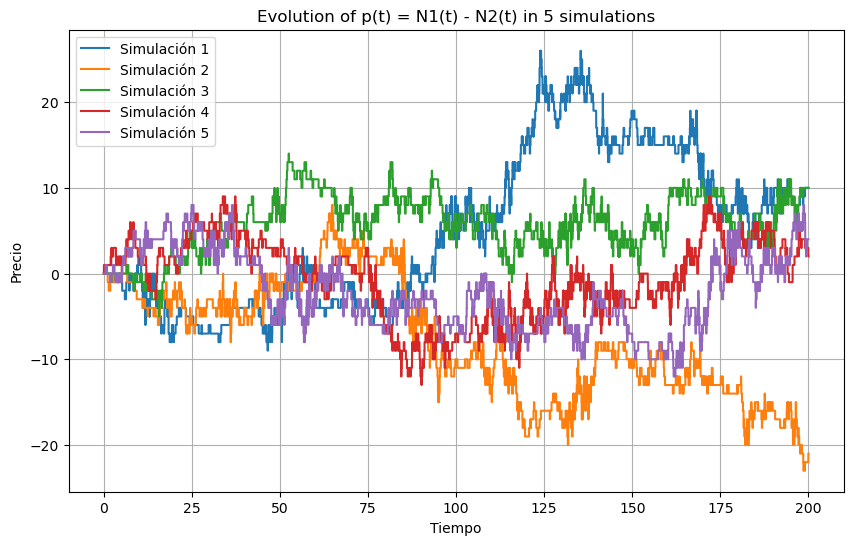

In [95]:
T = 200.0
lambda_0 = 0.5
alpha = 0.8
beta = 1.0

num_simulations = 5

plt.figure(figsize=(10, 6))

for sim in range(num_simulations):
    seed = 123 + sim
    ev1, ev2 = Hawkes_Thinning_Bivariate_Optimized(
        T, lambda_0, alpha, beta, seed=seed, verbose=False)
    
    plot_bivar_hawks(ev1, ev2, label=f'Simulación {sim+1}')

plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.title('Evolution of p(t) = N1(t) - N2(t) in 5 simulations')
plt.grid(True)
plt.legend()
plt.show()

### Fitting Hawkes model with empirical parameters.

T: 32280.0
Estimated parameters:
alpha: 0.28710878448549965
beta: 0.9965671451869272
lambda_0: 0.00011811202477890958


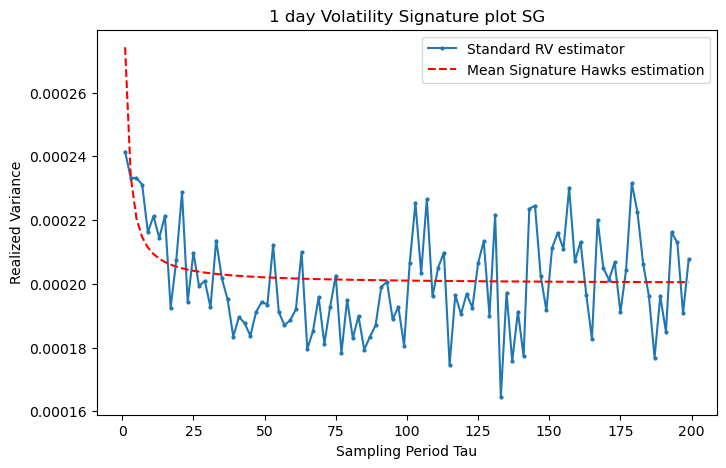

Estimated parameters:
alpha: 0.08413804374495026
beta: 0.6196160795864698
lambda_0: 9.243026585011897e-05


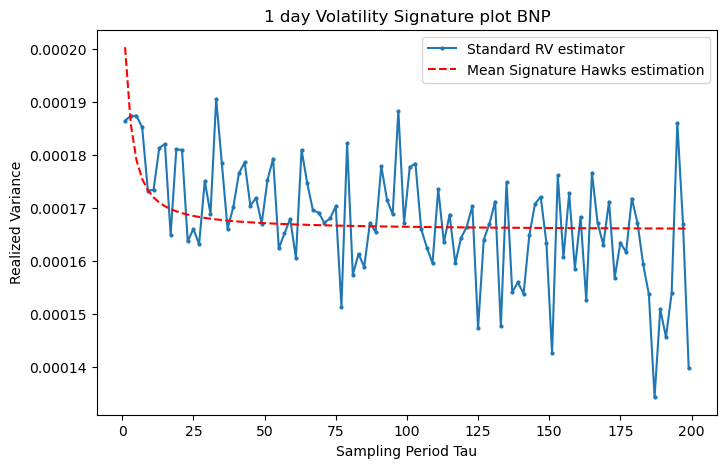

In [96]:
T = (end_dt - start_dt).total_seconds()
print("T:", T)

tau_list = list(range(1, 200, 2))
realized_variance_list_sg = []
for tau in tau_list:
    realized_variance_list_sg.append(
        realized_variance_estimator_resample(
            df_trades_sg[['eprice']], tau, start_dt, end_dt))
    
popt, pcov = curve_fit(
    mean_signature_hawks, tau_list, realized_variance_list_sg,
    p0=[0.5, 0.8, 1], bounds=([0, 0, 1e-4], [1, 1, 1]))
alpha_sg, beta_sg, lambda_0_sg = popt
print("Estimated parameters:")
print("alpha:", alpha_sg)
print("beta:", beta_sg)
print("lambda_0:", lambda_0_sg)

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_sg, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_sg, beta_sg, lambda_0_sg), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')
plt.title('1 day Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()


tau_list = list(range(1, 200, 2))
realized_variance_list_bnp = []
for tau in tau_list:
    realized_variance_list_bnp.append(
        realized_variance_estimator_resample(
            df_trades_bnp[['eprice']], tau, start_dt, end_dt))
    
popt, pcov = curve_fit(
    mean_signature_hawks, tau_list, realized_variance_list_bnp,
    p0=[0.5, 0.8, 1], bounds=([0, 0, 1e-5], [1, 1, 1]))
alpha_bnp, beta_bnp, lambda_0_bnp = popt
print("Estimated parameters:")
print("alpha:", alpha_bnp)
print("beta:", beta_bnp)
print("lambda_0:", lambda_0_bnp)

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_bnp, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_bnp, beta_bnp, lambda_0_bnp), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')
plt.title('1 day Volatility Signature plot BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

In [97]:
T = ( end_dt - start_dt).total_seconds()

ev1_sg, ev2_sg = Hawkes_Thinning_Bivariate_Optimized(
                                    T, lambda_0_sg, alpha_sg, beta_sg, 
                                    verbose=False, seed=123)
ev1_bnp, ev2_bnp = Hawkes_Thinning_Bivariate_Optimized(
                                    T, lambda_0_bnp, alpha_bnp, beta_bnp, 
                                    verbose=False, seed=124)

print("\nResults:")
print(f"SG: p(T) = N1(T) - N2(T) =", 
      f"{len(ev1_sg)} - {len(ev2_sg)} = {len(ev1_sg)-len(ev2_sg)}")
print(f"BNP: p(T) = N1(T) - N2(T) =", 
      f"{len(ev1_bnp)} - {len(ev2_bnp)} = {len(ev1_bnp)-len(ev2_bnp)}")


Results:
SG: p(T) = N1(T) - N2(T) = 10 - 8 = 2
BNP: p(T) = N1(T) - N2(T) = 2 - 4 = -2


As expected, low quantity of trades in a day from the empirical data.  

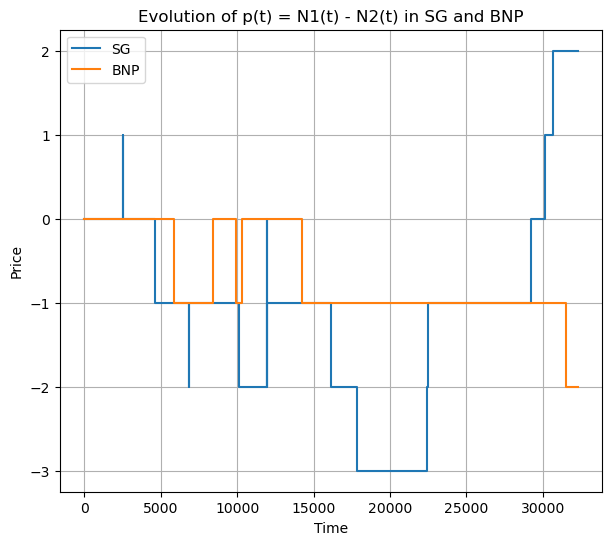

In [98]:
plt.figure(figsize = (7, 6))

plot_bivar_hawks(ev1_sg, ev2_sg, label = "SG")
plot_bivar_hawks(ev1_bnp, ev2_bnp, label = "BNP")
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Evolution of p(t) = N1(t) - N2(t) in SG and BNP')
plt.grid(True)
plt.legend()
plt.show()

### Signature plots of empirical, fitted and simulated data

In [99]:
def price_bivar_hawks (ev1, ev2, label = ""):
    events = [(t, +1) for t in ev1] + [(t, -1) for t in ev2]
    events.sort(key=lambda x: x[0])

    times = [0]
    prices = [0]
    price = 0

    for t_event, change in events:
        times.append(t_event)
        price += change
        prices.append(price)

    if times[-1] < T:
        times.append(T)
        prices.append(price)
    return times, prices

In [100]:
times_sg, prices_sg = price_bivar_hawks(ev1_sg, ev2_sg, label = "SG")
times_bnp, prices_bnp = price_bivar_hawks(ev1_bnp, ev2_bnp, label = "BNP")

prices_sg = np.exp(prices_sg)
prices_bnp = np.exp(prices_bnp)

In [101]:
df_simulation_sg = pd.DataFrame(
    {'ets': times_sg, 'price': prices_sg}).set_index('ets')
df_simulation_bnp = pd.DataFrame(
    {'ets': times_bnp, 'price': prices_bnp}).set_index('ets')

df_simulation_sg.index = start_dt + pd.to_timedelta(df_simulation_sg.index, unit='s')
df_simulation_bnp.index = start_dt + pd.to_timedelta(df_simulation_bnp.index, unit='s')

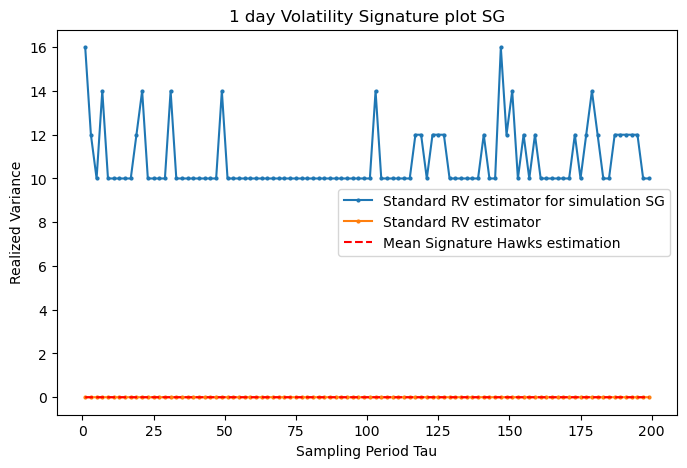

In [102]:
tau_list = list(range(1, 200, 2))
realized_variance_list_simulation_sg = []
for tau in tau_list:
    realized_variance_list_simulation_sg.append(
        realized_variance_estimator_resample(
            df_simulation_sg[['price']], tau, start_dt, end_dt))
    
plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_simulation_sg, 
         marker='o', markersize=2,
         label ='Standard RV estimator for simulation SG')
plt.plot(tau_list, realized_variance_list_sg, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_sg, beta_sg, lambda_0_sg), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')

plt.title('1 day Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

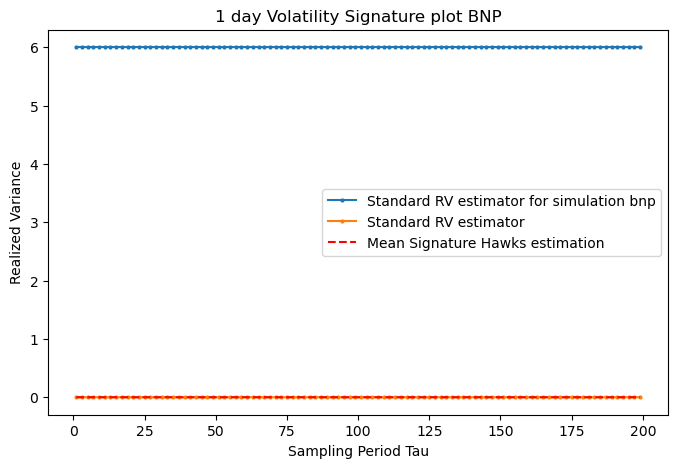

In [103]:
tau_list = list(range(1, 200, 2))
realized_variance_list_simulation_bnp = []
for tau in tau_list:
    realized_variance_list_simulation_bnp.append(
        realized_variance_estimator_resample(
            df_simulation_bnp[['price']], tau, start_dt, end_dt))
    
plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_simulation_bnp, 
         marker='o', markersize=2,
         label ='Standard RV estimator for simulation bnp')
plt.plot(tau_list, realized_variance_list_bnp, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_bnp, beta_bnp, lambda_0_bnp), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')

plt.title('1 day Volatility Signature plot BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

We can clearly see that the simulated data doesnt follow the same pattern as the empirical data. This is due to a flaw in our model implementation. We using the logarithm of the prices instead of the prices themselves. We used the log returns because in the beginning we used the assumptions of the Brownian motion. However, now we have a different model, we the prices now are modeled only by a bivariate hawkes process. Therefore, we should use the prices instead of the log returns. Also, we need to divide by the time length, since we are following the theory of the signature plot of the hawkes process.

---

### Signature plots of empirical, fitted and simulated data using **non** logarithmic prices

T: 32280.0
Estimated parameters:
alpha: 0.036167457240577384
beta: 0.266384985197434
lambda_0: 6.852711566296327


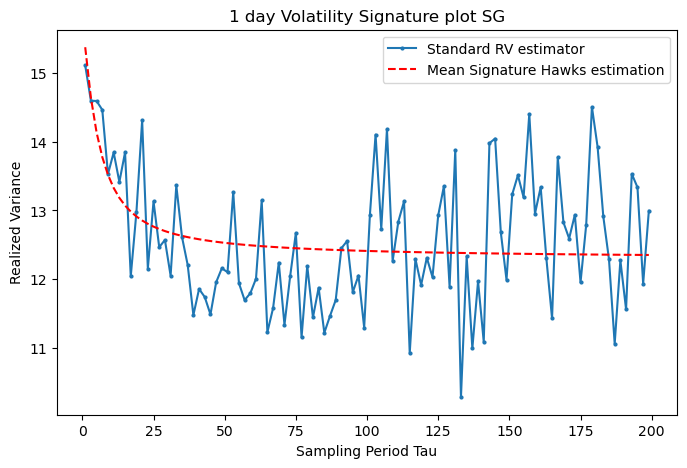

Estimated parameters:
alpha: 0.001214626356080537
beta: 0.011616984373638995
lambda_0: 8.808484979592109


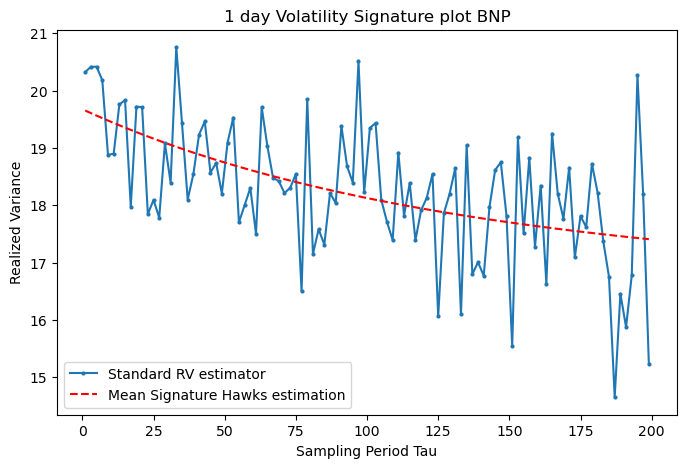

In [104]:
T = (end_dt - start_dt).total_seconds()
print("T:", T)

tau_list = list(range(1, 200, 2))
realized_variance_list_sg = []
for tau in tau_list:
    realized_variance_list_sg.append(
        realized_variance_estimator_resample(
            df_trades_sg[['eprice']], tau, start_dt, end_dt,
            log_prices=False) / T)
    
popt, pcov = curve_fit(
    mean_signature_hawks, tau_list, realized_variance_list_sg,
    p0=[0.5, 0.8, 1], bounds=([0, 0, 1e-5], [20, 20, 20]))
alpha_sg, beta_sg, lambda_0_sg = popt
print("Estimated parameters:")
print("alpha:", alpha_sg)
print("beta:", beta_sg)
print("lambda_0:", lambda_0_sg)

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_sg, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_sg, beta_sg, lambda_0_sg), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')
plt.title('1 day Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()


tau_list = list(range(1, 200, 2))
realized_variance_list_bnp = []
for tau in tau_list:
    realized_variance_list_bnp.append(
        realized_variance_estimator_resample(
            df_trades_bnp[['eprice']], tau, start_dt, end_dt,
            log_prices=False) / T)
    
popt, pcov = curve_fit(
    mean_signature_hawks, tau_list, realized_variance_list_bnp,
    p0=[0.5, 0.8, 1], bounds=([0, 0, 1e-5], [20, 20, 20]))
alpha_bnp, beta_bnp, lambda_0_bnp = popt
print("Estimated parameters:")
print("alpha:", alpha_bnp)
print("beta:", beta_bnp)
print("lambda_0:", lambda_0_bnp)

plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_bnp, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_bnp, beta_bnp, lambda_0_bnp), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')
plt.title('1 day Volatility Signature plot BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()


Results:
SG: p(T) = N1(T) - N2(T) = 256749 - 256432 = 317
BNP: p(T) = N1(T) - N2(T) = 316857 - 317643 = -786


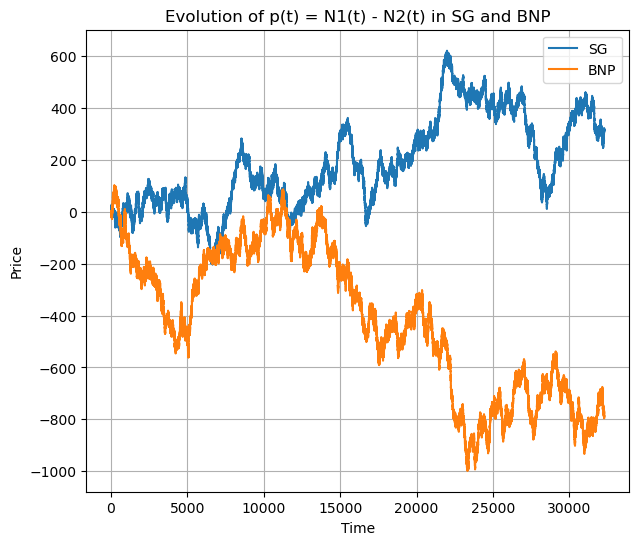

In [105]:
T = ( end_dt - start_dt).total_seconds()

ev1_sg, ev2_sg = Hawkes_Thinning_Bivariate_Optimized(
                                    T, lambda_0_sg, alpha_sg, beta_sg, 
                                    verbose=False, seed=123)
ev1_bnp, ev2_bnp = Hawkes_Thinning_Bivariate_Optimized(
                                    T, lambda_0_bnp, alpha_bnp, beta_bnp, 
                                    verbose=False, seed=124)

print("\nResults:")
print(f"SG: p(T) = N1(T) - N2(T) =", 
      f"{len(ev1_sg)} - {len(ev2_sg)} = {len(ev1_sg)-len(ev2_sg)}")
print(f"BNP: p(T) = N1(T) - N2(T) =", 
      f"{len(ev1_bnp)} - {len(ev2_bnp)} = {len(ev1_bnp)-len(ev2_bnp)}")

plt.figure(figsize = (7, 6))

plot_bivar_hawks(ev1_sg, ev2_sg, label = "SG")
plot_bivar_hawks(ev1_bnp, ev2_bnp, label = "BNP")
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Evolution of p(t) = N1(t) - N2(t) in SG and BNP')
plt.grid(True)
plt.legend()
plt.show()

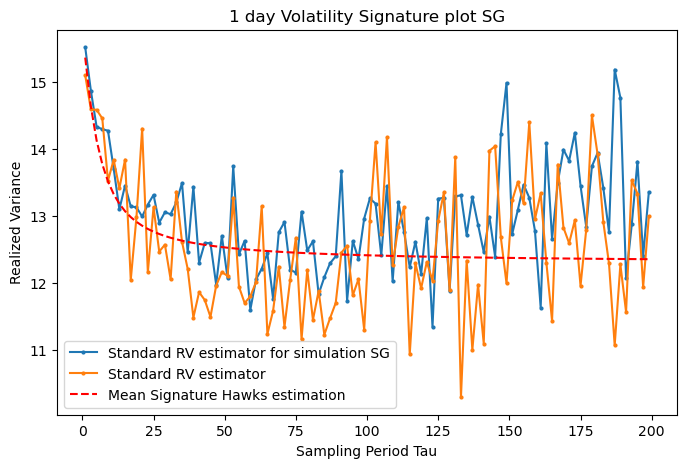

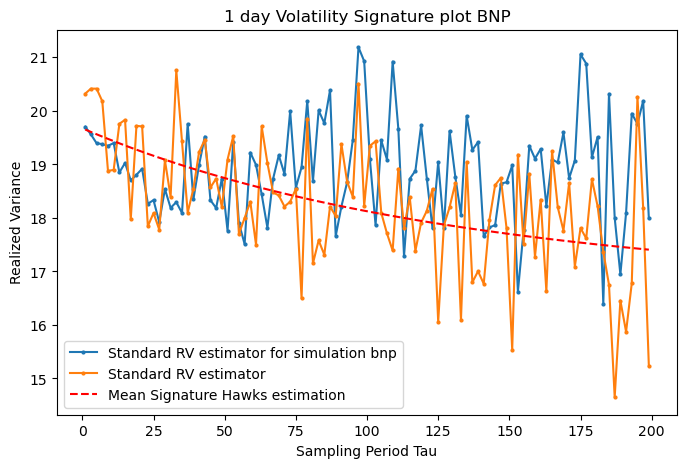

In [106]:
times_sg, prices_sg = price_bivar_hawks(ev1_sg, ev2_sg, label = "SG")
times_bnp, prices_bnp = price_bivar_hawks(ev1_bnp, ev2_bnp, label = "BNP")

df_simulation_sg = pd.DataFrame(
    {'ets': times_sg, 'price': prices_sg}).set_index('ets')
df_simulation_bnp = pd.DataFrame(
    {'ets': times_bnp, 'price': prices_bnp}).set_index('ets')

df_simulation_sg.index = start_dt + pd.to_timedelta(df_simulation_sg.index, unit='s')
df_simulation_bnp.index = start_dt + pd.to_timedelta(df_simulation_bnp.index, unit='s')

tau_list = list(range(1, 200, 2))
realized_variance_list_simulation_sg = []
for tau in tau_list:
    realized_variance_list_simulation_sg.append(
        realized_variance_estimator_resample(
            df_simulation_sg[['price']], tau, start_dt, end_dt,
            log_prices = False) / T)
    
plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_simulation_sg, 
         marker='o', markersize=2,
         label ='Standard RV estimator for simulation SG')
plt.plot(tau_list, realized_variance_list_sg, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_sg, beta_sg, lambda_0_sg), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')

plt.title('1 day Volatility Signature plot SG')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()


tau_list = list(range(1, 200, 2))
realized_variance_list_simulation_bnp = []
for tau in tau_list:
    realized_variance_list_simulation_bnp.append(
        realized_variance_estimator_resample(
            df_simulation_bnp[['price']], tau, start_dt, end_dt,
            log_prices = False) / T)
    
plt.figure(figsize=(8, 5))
plt.plot(tau_list, realized_variance_list_simulation_bnp, 
         marker='o', markersize=2,
         label ='Standard RV estimator for simulation bnp')
plt.plot(tau_list, realized_variance_list_bnp, marker='o', markersize=2,
         label ='Standard RV estimator')
plt.plot(tau_list, mean_signature_hawks(
    np.array(tau_list), alpha_bnp, beta_bnp, lambda_0_bnp), linestyle='--', 
         color='red',
         label='Mean Signature Hawks estimation')

plt.title('1 day Volatility Signature plot BNP')
plt.xlabel('Sampling Period Tau')
plt.ylabel('Realized Variance')
plt.legend()
plt.show()

### Conclusions

We obtained a significantly better fit to the data, closely capturing the empirical patterns observed. This suggests that the model provides a reasonably good representation of the underlying process when estimating the realized variance using the standard estimator. However, it is important to note that the standard estimator is not necessarily the most accurate tool for assessing this type of data. Additionally, the current model is purely mean-reverting and does not account for self-excitation — a key feature in high-frequency financial data. Self-excitation is particularly relevant as it contributes to the heavy-tailed nature of inter-arrival times, which is commonly observed in such settings.

Nonetheless, this model display a creative and innovative approach to modeling high-frequency data. We only used the realized variance to estimate the parameters of the model, and never touched the real prices, or the time differences.
